In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import epfl_campus
from time import time

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, 1000)

/home/tanke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
loader = Loader()

def generate_pcp_score(frame, params):
    global loader, gen
    alpha = 0.5
    
    Im, Y, Calib = epfl_campus.get(root, frame)
    heatmaps, pafs = loader.load_confidence_map_and_paf(
        'campus', Im, frame, dir=Settings['tmp'])
    detections = pose.estimate(Calib, heatmaps, pafs, 
                               settings=params, debug=False)
    #detections = gen.apply(detections)
    Humans = kth.transform3d_from_mscoco(detections)
    
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    del heatmaps
    del pafs
    del detections
    del Im
    del Y
    del Calib
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs

# ======================================
# RUN
# ======================================

ms_radius = [10, 20, 30, 40, 50, 60, 70, 90, 110, 120, 130, 140]
ms_between_distances = [10, 30, 50, 60, 70, 90, 110, 120, 130, 150]

hm_detection_thresholds = [.01, .05, .1, .2, .4]
pp_conflict_overlaps = [.2, .4, .6, .8]
min_joint_distances = [0, 20, 40, 50, 70, 100, 150]

TESTS = []


for radius in ms_radius:
    for between_distance in ms_between_distances:
        
        _START = time()
        print('\n--- next step ---')
        print('radius:', radius)
        print('between_distance:', between_distance)
        
        valid_frames = list(range(350, 470, 2)) + list(range(650, 750, 2))
        params = get_settings(scale_to_mm=1000,
                          hm_detection_threshold=0.05,
                          pp_conflict_overlap=0.4,
                          ms_radius=radius,
                          ms_between_distance=between_distance)
        
        
        PER_GTID = {}
        TESTS.append(PER_GTID)
        for frame in valid_frames:
            _start = time()
            L_Arms, U_Arms, L_Legs, U_Legs, GTIDs =\
                generate_pcp_score(frame, params)
            _end = time()
            print('frame ' + str(frame) + ', elapsed:', _end - _start)
            if len(L_Arms) > 0:
                for gtid, larms, uarms, llegs, ulegs in zip(
                    GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
                ):
                    if not gtid in PER_GTID:
                        PER_GTID[gtid] = {
                            'larms': [],
                            'uarms': [],
                            'llegs': [],
                            'ulegs': [],
                            'frame': []
                        }
                    PER_GTID[gtid]['larms'].append(larms)
                    PER_GTID[gtid]['uarms'].append(uarms)
                    PER_GTID[gtid]['llegs'].append(llegs)
                    PER_GTID[gtid]['ulegs'].append(ulegs)
                    PER_GTID[gtid]['frame'].append(frame)
                    #AVG.append((larms + uarms + llegs + ulegs)/4)
        _END = time()
        print('total step ELAPSED:', _END - _START)




--- next step ---
radius: 10
between_distance: 10
frame 350, elapsed: 1.210233449935913
frame 352, elapsed: 1.161463737487793
frame 354, elapsed: 1.1624982357025146
frame 356, elapsed: 1.150719404220581
frame 358, elapsed: 1.1057960987091064
frame 360, elapsed: 1.174884557723999
frame 362, elapsed: 1.115426778793335
frame 364, elapsed: 1.1260929107666016
frame 366, elapsed: 1.1103801727294922
frame 368, elapsed: 1.2344598770141602
frame 370, elapsed: 1.2282261848449707
frame 372, elapsed: 1.2346553802490234
frame 374, elapsed: 1.09257173538208
frame 376, elapsed: 1.1096704006195068
frame 378, elapsed: 1.1348938941955566
frame 380, elapsed: 0.40568971633911133
frame 382, elapsed: 0.3236117362976074
frame 384, elapsed: 0.36105895042419434
frame 386, elapsed: 0.32449841499328613
frame 388, elapsed: 0.339374303817749
frame 390, elapsed: 1.1014277935028076
frame 392, elapsed: 0.3317112922668457
frame 394, elapsed: 0.40166640281677246
frame 396, elapsed: 0.40317606925964355
frame 398, elaps

frame 722, elapsed: 1.0022797584533691
frame 724, elapsed: 0.875216007232666
frame 726, elapsed: 0.9272418022155762
frame 728, elapsed: 1.083571195602417
frame 730, elapsed: 1.4114336967468262
frame 732, elapsed: 1.003770112991333
frame 734, elapsed: 1.7473556995391846
frame 736, elapsed: 1.349886417388916
frame 738, elapsed: 1.2519867420196533
frame 740, elapsed: 1.4082624912261963
frame 742, elapsed: 8.303023099899292
frame 744, elapsed: 1.2704048156738281
frame 746, elapsed: 1.655346393585205
frame 748, elapsed: 2.0747737884521484
total step ELAPSED: 72.91163492202759

--- next step ---
radius: 10
between_distance: 50
frame 350, elapsed: 0.2878561019897461
frame 352, elapsed: 0.29923510551452637
frame 354, elapsed: 0.3112814426422119
frame 356, elapsed: 0.2975587844848633
frame 358, elapsed: 0.34085845947265625
frame 360, elapsed: 0.3279299736022949
frame 362, elapsed: 0.29955101013183594
frame 364, elapsed: 0.2957942485809326
frame 366, elapsed: 0.2930779457092285
frame 368, elapse

frame 692, elapsed: 0.5240321159362793
frame 694, elapsed: 0.675116777420044
frame 696, elapsed: 0.6797399520874023
frame 698, elapsed: 0.7610435485839844
frame 700, elapsed: 0.8763065338134766
frame 702, elapsed: 1.4861729145050049
frame 704, elapsed: 0.665431022644043
frame 706, elapsed: 0.6633844375610352
frame 708, elapsed: 1.0091521739959717
frame 710, elapsed: 0.7204782962799072
frame 712, elapsed: 0.7569425106048584
frame 714, elapsed: 0.7074539661407471
frame 716, elapsed: 0.7600562572479248
frame 718, elapsed: 0.8347570896148682
frame 720, elapsed: 0.7885797023773193
frame 722, elapsed: 0.7711920738220215
frame 724, elapsed: 0.768613338470459
frame 726, elapsed: 0.8111560344696045
frame 728, elapsed: 1.1106600761413574
frame 730, elapsed: 0.9862234592437744
frame 732, elapsed: 0.8715331554412842
frame 734, elapsed: 1.4880659580230713
frame 736, elapsed: 0.9426419734954834
frame 738, elapsed: 1.0034711360931396
frame 740, elapsed: 1.1113624572753906
frame 742, elapsed: 1.945083

frame 662, elapsed: 0.3693211078643799
frame 664, elapsed: 0.3642311096191406
frame 666, elapsed: 0.36760568618774414
frame 668, elapsed: 0.32117700576782227
frame 670, elapsed: 0.3597233295440674
frame 672, elapsed: 0.3399362564086914
frame 674, elapsed: 0.3411831855773926
frame 676, elapsed: 0.4640040397644043
frame 678, elapsed: 0.3660874366760254
frame 680, elapsed: 0.4162933826446533
frame 682, elapsed: 0.3998086452484131
frame 684, elapsed: 0.513420581817627
frame 686, elapsed: 0.39571690559387207
frame 688, elapsed: 0.46387362480163574
frame 690, elapsed: 0.40014100074768066
frame 692, elapsed: 0.42075181007385254
frame 694, elapsed: 0.6417641639709473
frame 696, elapsed: 0.5993473529815674
frame 698, elapsed: 0.7041440010070801
frame 700, elapsed: 0.7895879745483398
frame 702, elapsed: 1.1809039115905762
frame 704, elapsed: 0.6112315654754639
frame 706, elapsed: 0.600471019744873
frame 708, elapsed: 0.8231103420257568
frame 710, elapsed: 0.7130835056304932
frame 712, elapsed: 0

frame 452, elapsed: 0.33333730697631836
frame 454, elapsed: 0.4605116844177246
frame 456, elapsed: 0.30136752128601074
frame 458, elapsed: 0.3140451908111572
frame 460, elapsed: 0.3080258369445801
frame 462, elapsed: 0.2888345718383789
frame 464, elapsed: 0.29419565200805664
frame 466, elapsed: 0.2992286682128906
frame 468, elapsed: 0.3102695941925049
frame 650, elapsed: 0.30213499069213867
frame 652, elapsed: 0.3092963695526123
frame 654, elapsed: 0.3261444568634033
frame 656, elapsed: 0.33415913581848145
frame 658, elapsed: 0.3105320930480957
frame 660, elapsed: 0.31723833084106445
frame 662, elapsed: 0.3284473419189453
frame 664, elapsed: 0.3292572498321533
frame 666, elapsed: 0.3425633907318115
frame 668, elapsed: 0.31054043769836426
frame 670, elapsed: 0.347426176071167
frame 672, elapsed: 0.33263444900512695
frame 674, elapsed: 0.3246040344238281
frame 676, elapsed: 0.43065977096557617
frame 678, elapsed: 0.35622453689575195
frame 680, elapsed: 0.375333309173584
frame 682, elapse

frame 422, elapsed: 0.3262193202972412
frame 424, elapsed: 0.33350110054016113
frame 426, elapsed: 0.3505055904388428
frame 428, elapsed: 0.3130519390106201
frame 430, elapsed: 0.3170034885406494
frame 432, elapsed: 0.3215513229370117
frame 434, elapsed: 0.3517627716064453
frame 436, elapsed: 0.3443634510040283
frame 438, elapsed: 0.34153008460998535
frame 440, elapsed: 0.3477959632873535
frame 442, elapsed: 0.29970812797546387
frame 444, elapsed: 0.3244485855102539
frame 446, elapsed: 0.34369468688964844
frame 448, elapsed: 0.34531497955322266
frame 450, elapsed: 0.37245726585388184
frame 452, elapsed: 0.31517982482910156
frame 454, elapsed: 0.4058406352996826
frame 456, elapsed: 0.28800415992736816
frame 458, elapsed: 0.27585697174072266
frame 460, elapsed: 0.29578113555908203
frame 462, elapsed: 0.284853458404541
frame 464, elapsed: 0.288161039352417
frame 466, elapsed: 0.30063796043395996
frame 468, elapsed: 0.30487489700317383
frame 650, elapsed: 0.2960174083709717
frame 652, elap

frame 392, elapsed: 0.3004581928253174
frame 394, elapsed: 0.35354161262512207
frame 396, elapsed: 0.3491532802581787
frame 398, elapsed: 0.3736991882324219
frame 400, elapsed: 0.38812756538391113
frame 402, elapsed: 0.40085530281066895
frame 404, elapsed: 0.38849329948425293
frame 406, elapsed: 0.3752422332763672
frame 408, elapsed: 0.432445764541626
frame 410, elapsed: 0.5461828708648682
frame 412, elapsed: 0.5145010948181152
frame 414, elapsed: 0.4003589153289795
frame 416, elapsed: 0.5118861198425293
frame 418, elapsed: 0.4161813259124756
frame 420, elapsed: 0.3954474925994873
frame 422, elapsed: 0.4146108627319336
frame 424, elapsed: 0.43535494804382324
frame 426, elapsed: 0.49889636039733887
frame 428, elapsed: 0.39769959449768066
frame 430, elapsed: 0.4766368865966797
frame 432, elapsed: 0.40573954582214355
frame 434, elapsed: 0.43010640144348145
frame 436, elapsed: 0.49965572357177734
frame 438, elapsed: 0.5017478466033936
frame 440, elapsed: 0.5096712112426758
frame 442, elaps

frame 362, elapsed: 0.3070535659790039
frame 364, elapsed: 0.2989206314086914
frame 366, elapsed: 0.29439592361450195
frame 368, elapsed: 0.2898399829864502
frame 370, elapsed: 0.2904245853424072
frame 372, elapsed: 0.28992366790771484
frame 374, elapsed: 0.28868746757507324
frame 376, elapsed: 0.28624892234802246
frame 378, elapsed: 0.34734225273132324
frame 380, elapsed: 0.2995474338531494
frame 382, elapsed: 0.3010408878326416
frame 384, elapsed: 0.2961699962615967
frame 386, elapsed: 0.29410266876220703
frame 388, elapsed: 0.2975575923919678
frame 390, elapsed: 0.2875809669494629
frame 392, elapsed: 0.306260347366333
frame 394, elapsed: 0.33443617820739746
frame 396, elapsed: 0.3376941680908203
frame 398, elapsed: 0.3557858467102051
frame 400, elapsed: 0.3757038116455078
frame 402, elapsed: 0.3524441719055176
frame 404, elapsed: 0.3621187210083008
frame 406, elapsed: 0.3359415531158447
frame 408, elapsed: 0.3430461883544922
frame 410, elapsed: 0.46019768714904785
frame 412, elapsed

frame 736, elapsed: 0.9742906093597412
frame 738, elapsed: 0.8734042644500732
frame 740, elapsed: 0.898993968963623
frame 742, elapsed: 0.9108161926269531
frame 744, elapsed: 1.1694426536560059
frame 746, elapsed: 1.341304063796997
frame 748, elapsed: 3.0439939498901367
total step ELAPSED: 56.80276417732239

--- next step ---
radius: 20
between_distance: 90
frame 350, elapsed: 0.3521873950958252
frame 352, elapsed: 0.3267326354980469
frame 354, elapsed: 0.3452494144439697
frame 356, elapsed: 0.3446071147918701
frame 358, elapsed: 0.33397626876831055
frame 360, elapsed: 0.3405590057373047
frame 362, elapsed: 0.3009004592895508
frame 364, elapsed: 0.2935450077056885
frame 366, elapsed: 0.2948448657989502
frame 368, elapsed: 0.3414022922515869
frame 370, elapsed: 0.29712343215942383
frame 372, elapsed: 0.28154706954956055
frame 374, elapsed: 0.31953954696655273
frame 376, elapsed: 0.32716941833496094
frame 378, elapsed: 0.2964634895324707
frame 380, elapsed: 0.28542518615722656
frame 382,

frame 706, elapsed: 0.5587277412414551
frame 708, elapsed: 0.6964080333709717
frame 710, elapsed: 0.6271789073944092
frame 712, elapsed: 0.7871906757354736
frame 714, elapsed: 0.643418550491333
frame 716, elapsed: 0.7318611145019531
frame 718, elapsed: 0.7303574085235596
frame 720, elapsed: 0.6159529685974121
frame 722, elapsed: 0.6626873016357422
frame 724, elapsed: 0.6474740505218506
frame 726, elapsed: 0.6509802341461182
frame 728, elapsed: 0.9160678386688232
frame 730, elapsed: 0.9311869144439697
frame 732, elapsed: 0.6377413272857666
frame 734, elapsed: 0.7130489349365234
frame 736, elapsed: 0.6889533996582031
frame 738, elapsed: 0.6819479465484619
frame 740, elapsed: 0.7092411518096924
frame 742, elapsed: 1.3689491748809814
frame 744, elapsed: 1.5957379341125488
frame 746, elapsed: 1.7044711112976074
frame 748, elapsed: 2.0466837882995605
total step ELAPSED: 50.50844693183899

--- next step ---
radius: 20
between_distance: 120
frame 350, elapsed: 0.28713297843933105
frame 352, el

frame 674, elapsed: 0.37111973762512207
frame 676, elapsed: 0.4103567600250244
frame 678, elapsed: 0.4014766216278076
frame 680, elapsed: 0.398557186126709
frame 682, elapsed: 0.3756129741668701
frame 684, elapsed: 0.5285744667053223
frame 686, elapsed: 0.42960190773010254
frame 688, elapsed: 0.43534421920776367
frame 690, elapsed: 0.4176959991455078
frame 692, elapsed: 0.4128596782684326
frame 694, elapsed: 0.7588224411010742
frame 696, elapsed: 0.6421749591827393
frame 698, elapsed: 0.6126954555511475
frame 700, elapsed: 0.5876028537750244
frame 702, elapsed: 0.7874538898468018
frame 704, elapsed: 0.5746629238128662
frame 706, elapsed: 0.5720086097717285
frame 708, elapsed: 0.6671929359436035
frame 710, elapsed: 0.6360166072845459
frame 712, elapsed: 0.564154863357544
frame 714, elapsed: 0.5928294658660889
frame 716, elapsed: 0.5656523704528809
frame 718, elapsed: 0.6044316291809082
frame 720, elapsed: 0.5163083076477051
frame 722, elapsed: 0.6275649070739746
frame 724, elapsed: 0.58

frame 464, elapsed: 0.4262826442718506
frame 466, elapsed: 0.4453146457672119
frame 468, elapsed: 0.4441721439361572
frame 650, elapsed: 0.39699697494506836
frame 652, elapsed: 0.4616217613220215
frame 654, elapsed: 0.4151310920715332
frame 656, elapsed: 0.45550084114074707
frame 658, elapsed: 0.47362208366394043
frame 660, elapsed: 0.4558229446411133
frame 662, elapsed: 0.5555660724639893
frame 664, elapsed: 0.5655276775360107
frame 666, elapsed: 0.5064527988433838
frame 668, elapsed: 0.352916955947876
frame 670, elapsed: 0.4526486396789551
frame 672, elapsed: 0.4263143539428711
frame 674, elapsed: 0.37344813346862793
frame 676, elapsed: 0.5578906536102295
frame 678, elapsed: 0.4382288455963135
frame 680, elapsed: 0.506514310836792
frame 682, elapsed: 0.4837520122528076
frame 684, elapsed: 0.7318453788757324
frame 686, elapsed: 0.4563009738922119
frame 688, elapsed: 0.6443212032318115
frame 690, elapsed: 0.4541051387786865
frame 692, elapsed: 0.5867764949798584
frame 694, elapsed: 0.6

frame 434, elapsed: 0.39156222343444824
frame 436, elapsed: 0.437349796295166
frame 438, elapsed: 0.4520092010498047
frame 440, elapsed: 0.5110023021697998
frame 442, elapsed: 0.3531777858734131
frame 444, elapsed: 0.4153780937194824
frame 446, elapsed: 0.4615929126739502
frame 448, elapsed: 0.29065728187561035
frame 450, elapsed: 0.42598962783813477
frame 452, elapsed: 0.4553980827331543
frame 454, elapsed: 0.6190178394317627
frame 456, elapsed: 0.30725622177124023
frame 458, elapsed: 0.31071043014526367
frame 460, elapsed: 0.3142573833465576
frame 462, elapsed: 0.30799293518066406
frame 464, elapsed: 0.3629417419433594
frame 466, elapsed: 0.39697766304016113
frame 468, elapsed: 0.4004216194152832
frame 650, elapsed: 0.3591749668121338
frame 652, elapsed: 0.38813257217407227
frame 654, elapsed: 0.3982517719268799
frame 656, elapsed: 0.428053617477417
frame 658, elapsed: 0.3803284168243408
frame 660, elapsed: 0.3710031509399414
frame 662, elapsed: 0.38079833984375
frame 664, elapsed: 0

frame 404, elapsed: 0.3592565059661865
frame 406, elapsed: 0.32993054389953613
frame 408, elapsed: 0.350665807723999
frame 410, elapsed: 0.3954501152038574
frame 412, elapsed: 0.4145498275756836
frame 414, elapsed: 0.36687135696411133
frame 416, elapsed: 0.3918638229370117
frame 418, elapsed: 0.379575252532959
frame 420, elapsed: 0.3309156894683838
frame 422, elapsed: 0.3523080348968506
frame 424, elapsed: 0.3669555187225342
frame 426, elapsed: 0.4054436683654785
frame 428, elapsed: 0.33995985984802246
frame 430, elapsed: 0.34232330322265625
frame 432, elapsed: 0.3461892604827881
frame 434, elapsed: 0.37653541564941406
frame 436, elapsed: 0.3867335319519043
frame 438, elapsed: 0.3777787685394287
frame 440, elapsed: 0.39183568954467773
frame 442, elapsed: 0.3136739730834961
frame 444, elapsed: 0.36359381675720215
frame 446, elapsed: 0.3182086944580078
frame 448, elapsed: 0.28773069381713867
frame 450, elapsed: 0.3719618320465088
frame 452, elapsed: 0.5366811752319336
frame 454, elapsed:

frame 374, elapsed: 0.2777862548828125
frame 376, elapsed: 0.28617215156555176
frame 378, elapsed: 0.28333282470703125
frame 380, elapsed: 0.29662585258483887
frame 382, elapsed: 0.29275965690612793
frame 384, elapsed: 0.2975168228149414
frame 386, elapsed: 0.2940530776977539
frame 388, elapsed: 0.29383349418640137
frame 390, elapsed: 0.28795576095581055
frame 392, elapsed: 0.30908966064453125
frame 394, elapsed: 0.3044722080230713
frame 396, elapsed: 0.32790160179138184
frame 398, elapsed: 0.3435378074645996
frame 400, elapsed: 0.3593730926513672
frame 402, elapsed: 0.36681079864501953
frame 404, elapsed: 0.3300042152404785
frame 406, elapsed: 0.4021611213684082
frame 408, elapsed: 0.4044368267059326
frame 410, elapsed: 0.39447855949401855
frame 412, elapsed: 0.3876626491546631
frame 414, elapsed: 0.3417050838470459
frame 416, elapsed: 0.3507676124572754
frame 418, elapsed: 0.3677184581756592
frame 420, elapsed: 0.3207569122314453
frame 422, elapsed: 0.3585846424102783
frame 424, elap

frame 748, elapsed: 0.6973452568054199
total step ELAPSED: 46.060510873794556

--- next step ---
radius: 30
between_distance: 130
frame 350, elapsed: 0.2865464687347412
frame 352, elapsed: 0.2837357521057129
frame 354, elapsed: 0.2856736183166504
frame 356, elapsed: 0.2830033302307129
frame 358, elapsed: 0.2875392436981201
frame 360, elapsed: 0.35249924659729004
frame 362, elapsed: 0.28818273544311523
frame 364, elapsed: 0.28668856620788574
frame 366, elapsed: 0.2816641330718994
frame 368, elapsed: 0.28342604637145996
frame 370, elapsed: 0.2825431823730469
frame 372, elapsed: 0.28122496604919434
frame 374, elapsed: 0.2765812873840332
frame 376, elapsed: 0.28278493881225586
frame 378, elapsed: 0.27790331840515137
frame 380, elapsed: 0.2894606590270996
frame 382, elapsed: 0.28821825981140137
frame 384, elapsed: 0.28551578521728516
frame 386, elapsed: 0.284088134765625
frame 388, elapsed: 0.28780221939086914
frame 390, elapsed: 0.2798798084259033
frame 392, elapsed: 0.28667283058166504
fr

frame 716, elapsed: 0.5367870330810547
frame 718, elapsed: 0.5298082828521729
frame 720, elapsed: 0.5103960037231445
frame 722, elapsed: 0.5808563232421875
frame 724, elapsed: 0.5886900424957275
frame 726, elapsed: 0.537961483001709
frame 728, elapsed: 0.6132481098175049
frame 730, elapsed: 0.6960146427154541
frame 732, elapsed: 0.6561224460601807
frame 734, elapsed: 0.669825553894043
frame 736, elapsed: 0.5985541343688965
frame 738, elapsed: 0.636669397354126
frame 740, elapsed: 0.6561527252197266
frame 742, elapsed: 0.5768249034881592
frame 744, elapsed: 0.6257138252258301
frame 746, elapsed: 0.567192792892456
frame 748, elapsed: 0.6248290538787842
total step ELAPSED: 42.598063945770264

--- next step ---
radius: 40
between_distance: 10
frame 350, elapsed: 0.31943511962890625
frame 352, elapsed: 0.3791470527648926
frame 354, elapsed: 0.3299520015716553
frame 356, elapsed: 0.3304293155670166
frame 358, elapsed: 0.32964086532592773
frame 360, elapsed: 0.3313405513763428
frame 362, elap

frame 686, elapsed: 0.4556155204772949
frame 688, elapsed: 0.5494964122772217
frame 690, elapsed: 0.4336071014404297
frame 692, elapsed: 0.5911667346954346
frame 694, elapsed: 0.7312891483306885
frame 696, elapsed: 0.7581892013549805
frame 698, elapsed: 0.8873324394226074
frame 700, elapsed: 1.1484522819519043
frame 702, elapsed: 2.2213385105133057
frame 704, elapsed: 0.6930623054504395
frame 706, elapsed: 0.7193994522094727
frame 708, elapsed: 1.0271940231323242
frame 710, elapsed: 0.801419734954834
frame 712, elapsed: 0.9024531841278076
frame 714, elapsed: 0.7482945919036865
frame 716, elapsed: 0.9087004661560059
frame 718, elapsed: 0.7577931880950928
frame 720, elapsed: 0.7611286640167236
frame 722, elapsed: 0.8636023998260498
frame 724, elapsed: 0.9936206340789795
frame 726, elapsed: 0.8114538192749023
frame 728, elapsed: 1.1158616542816162
frame 730, elapsed: 0.9266982078552246
frame 732, elapsed: 0.8415546417236328
frame 734, elapsed: 1.326369285583496
frame 736, elapsed: 1.26573

frame 656, elapsed: 0.37467265129089355
frame 658, elapsed: 0.3491191864013672
frame 660, elapsed: 0.34714627265930176
frame 662, elapsed: 0.3633842468261719
frame 664, elapsed: 0.38010501861572266
frame 666, elapsed: 0.39522552490234375
frame 668, elapsed: 0.3383021354675293
frame 670, elapsed: 0.4093015193939209
frame 672, elapsed: 0.3790571689605713
frame 674, elapsed: 0.35987305641174316
frame 676, elapsed: 0.5063338279724121
frame 678, elapsed: 0.43811774253845215
frame 680, elapsed: 0.5397789478302002
frame 682, elapsed: 0.4620034694671631
frame 684, elapsed: 0.6475968360900879
frame 686, elapsed: 0.4491610527038574
frame 688, elapsed: 0.49917054176330566
frame 690, elapsed: 0.4208340644836426
frame 692, elapsed: 0.5144672393798828
frame 694, elapsed: 0.6997575759887695
frame 696, elapsed: 0.7152900695800781
frame 698, elapsed: 0.7715170383453369
frame 700, elapsed: 0.7147393226623535
frame 702, elapsed: 1.404212474822998
frame 704, elapsed: 0.6750457286834717
frame 706, elapsed:

frame 446, elapsed: 0.31145358085632324
frame 448, elapsed: 0.2876713275909424
frame 450, elapsed: 0.34580278396606445
frame 452, elapsed: 0.324995756149292
frame 454, elapsed: 0.40251588821411133
frame 456, elapsed: 0.29282641410827637
frame 458, elapsed: 0.28323841094970703
frame 460, elapsed: 0.3032717704772949
frame 462, elapsed: 0.2926619052886963
frame 464, elapsed: 0.30573272705078125
frame 466, elapsed: 0.3263211250305176
frame 468, elapsed: 0.375701904296875
frame 650, elapsed: 0.31912827491760254
frame 652, elapsed: 0.3303802013397217
frame 654, elapsed: 0.3562743663787842
frame 656, elapsed: 0.3719031810760498
frame 658, elapsed: 0.321699857711792
frame 660, elapsed: 0.32325148582458496
frame 662, elapsed: 0.3563978672027588
frame 664, elapsed: 0.3525524139404297
frame 666, elapsed: 0.36513233184814453
frame 668, elapsed: 0.32001590728759766
frame 670, elapsed: 0.36356663703918457
frame 672, elapsed: 0.34372735023498535
frame 674, elapsed: 0.3925650119781494
frame 676, elaps

frame 416, elapsed: 0.38039445877075195
frame 418, elapsed: 0.39293742179870605
frame 420, elapsed: 0.3591907024383545
frame 422, elapsed: 0.32927870750427246
frame 424, elapsed: 0.3531029224395752
frame 426, elapsed: 0.4386177062988281
frame 428, elapsed: 0.31842780113220215
frame 430, elapsed: 0.36972641944885254
frame 432, elapsed: 0.4376401901245117
frame 434, elapsed: 0.4171473979949951
frame 436, elapsed: 0.39809656143188477
frame 438, elapsed: 0.3910696506500244
frame 440, elapsed: 0.42456746101379395
frame 442, elapsed: 0.3467886447906494
frame 444, elapsed: 0.35051465034484863
frame 446, elapsed: 0.369304895401001
frame 448, elapsed: 0.31708621978759766
frame 450, elapsed: 0.3614513874053955
frame 452, elapsed: 0.3517148494720459
frame 454, elapsed: 0.4194023609161377
frame 456, elapsed: 0.3201017379760742
frame 458, elapsed: 0.29718971252441406
frame 460, elapsed: 0.33368825912475586
frame 462, elapsed: 0.28856348991394043
frame 464, elapsed: 0.2969074249267578
frame 466, ela

frame 386, elapsed: 0.281665563583374
frame 388, elapsed: 0.27650880813598633
frame 390, elapsed: 0.27592897415161133
frame 392, elapsed: 0.2828648090362549
frame 394, elapsed: 0.2910447120666504
frame 396, elapsed: 0.2943539619445801
frame 398, elapsed: 0.3063981533050537
frame 400, elapsed: 0.3125004768371582
frame 402, elapsed: 0.315685510635376
frame 404, elapsed: 0.31690549850463867
frame 406, elapsed: 0.319627046585083
frame 408, elapsed: 0.324718713760376
frame 410, elapsed: 0.3341257572174072
frame 412, elapsed: 0.34587979316711426
frame 414, elapsed: 0.3173062801361084
frame 416, elapsed: 0.32442235946655273
frame 418, elapsed: 0.3091597557067871
frame 420, elapsed: 0.2950913906097412
frame 422, elapsed: 0.3176612854003906
frame 424, elapsed: 0.3832583427429199
frame 426, elapsed: 0.33910632133483887
frame 428, elapsed: 0.3165616989135742
frame 430, elapsed: 0.3090534210205078
frame 432, elapsed: 0.3163125514984131
frame 434, elapsed: 0.3399653434753418
frame 436, elapsed: 0.3

frame 356, elapsed: 0.31383490562438965
frame 358, elapsed: 0.3145458698272705
frame 360, elapsed: 0.30762624740600586
frame 362, elapsed: 0.30760979652404785
frame 364, elapsed: 0.2985820770263672
frame 366, elapsed: 0.2998816967010498
frame 368, elapsed: 0.30452728271484375
frame 370, elapsed: 0.31056880950927734
frame 372, elapsed: 0.3074054718017578
frame 374, elapsed: 0.2947859764099121
frame 376, elapsed: 0.28594255447387695
frame 378, elapsed: 0.2897369861602783
frame 380, elapsed: 0.30661582946777344
frame 382, elapsed: 0.31128430366516113
frame 384, elapsed: 0.3522317409515381
frame 386, elapsed: 0.3008298873901367
frame 388, elapsed: 0.30280208587646484
frame 390, elapsed: 0.29659461975097656
frame 392, elapsed: 0.3033761978149414
frame 394, elapsed: 0.3343923091888428
frame 396, elapsed: 0.34752702713012695
frame 398, elapsed: 0.3576009273529053
frame 400, elapsed: 0.38282036781311035
frame 402, elapsed: 0.3715479373931885
frame 404, elapsed: 0.3723945617675781
frame 406, el

frame 730, elapsed: 1.0495166778564453
frame 732, elapsed: 1.1526789665222168
frame 734, elapsed: 1.3543565273284912
frame 736, elapsed: 0.991135835647583
frame 738, elapsed: 1.0674102306365967
frame 740, elapsed: 1.0799560546875
frame 742, elapsed: 8.342573881149292
frame 744, elapsed: 1.0812420845031738
frame 746, elapsed: 1.1273715496063232
frame 748, elapsed: 1.4292385578155518
total step ELAPSED: 64.97218441963196

--- next step ---
radius: 50
between_distance: 60
frame 350, elapsed: 0.3160974979400635
frame 352, elapsed: 0.30467796325683594
frame 354, elapsed: 0.3046238422393799
frame 356, elapsed: 0.3009946346282959
frame 358, elapsed: 0.29775452613830566
frame 360, elapsed: 0.3280317783355713
frame 362, elapsed: 0.29421353340148926
frame 364, elapsed: 0.28730034828186035
frame 366, elapsed: 0.28693175315856934
frame 368, elapsed: 0.29423046112060547
frame 370, elapsed: 0.2914443016052246
frame 372, elapsed: 0.298412561416626
frame 374, elapsed: 0.28551173210144043
frame 376, el

frame 698, elapsed: 0.7099654674530029
frame 700, elapsed: 0.7618522644042969
frame 702, elapsed: 1.4769458770751953
frame 704, elapsed: 0.7479023933410645
frame 706, elapsed: 0.6956274509429932
frame 708, elapsed: 0.9697067737579346
frame 710, elapsed: 0.7256712913513184
frame 712, elapsed: 0.7394366264343262
frame 714, elapsed: 0.7543268203735352
frame 716, elapsed: 0.7229619026184082
frame 718, elapsed: 0.816974401473999
frame 720, elapsed: 0.7881596088409424
frame 722, elapsed: 0.9804723262786865
frame 724, elapsed: 0.7715041637420654
frame 726, elapsed: 0.817453145980835
frame 728, elapsed: 0.8670623302459717
frame 730, elapsed: 0.8313608169555664
frame 732, elapsed: 0.8644957542419434
frame 734, elapsed: 1.1588008403778076
frame 736, elapsed: 0.8699591159820557
frame 738, elapsed: 0.9298558235168457
frame 740, elapsed: 0.8697178363800049
frame 742, elapsed: 0.7846276760101318
frame 744, elapsed: 1.3049168586730957
frame 746, elapsed: 1.3161096572875977
frame 748, elapsed: 2.76802

frame 668, elapsed: 0.3140285015106201
frame 670, elapsed: 0.359752893447876
frame 672, elapsed: 0.35016822814941406
frame 674, elapsed: 0.3338160514831543
frame 676, elapsed: 0.46574902534484863
frame 678, elapsed: 0.36356067657470703
frame 680, elapsed: 0.3832557201385498
frame 682, elapsed: 0.3746318817138672
frame 684, elapsed: 0.5165777206420898
frame 686, elapsed: 0.38243985176086426
frame 688, elapsed: 0.4344804286956787
frame 690, elapsed: 0.38054394721984863
frame 692, elapsed: 0.39646053314208984
frame 694, elapsed: 0.5297996997833252
frame 696, elapsed: 0.5899453163146973
frame 698, elapsed: 0.6077861785888672
frame 700, elapsed: 0.6600804328918457
frame 702, elapsed: 0.7612133026123047
frame 704, elapsed: 0.5607388019561768
frame 706, elapsed: 0.5546302795410156
frame 708, elapsed: 0.6408679485321045
frame 710, elapsed: 0.6055440902709961
frame 712, elapsed: 0.6866579055786133
frame 714, elapsed: 0.618659257888794
frame 716, elapsed: 0.6390933990478516
frame 718, elapsed: 0

frame 458, elapsed: 0.2802150249481201
frame 460, elapsed: 0.3022453784942627
frame 462, elapsed: 0.2896006107330322
frame 464, elapsed: 0.2956502437591553
frame 466, elapsed: 0.2997164726257324
frame 468, elapsed: 0.3082447052001953
frame 650, elapsed: 0.2988910675048828
frame 652, elapsed: 0.3072774410247803
frame 654, elapsed: 0.3337266445159912
frame 656, elapsed: 0.3357880115509033
frame 658, elapsed: 0.31493377685546875
frame 660, elapsed: 0.31420278549194336
frame 662, elapsed: 0.3209860324859619
frame 664, elapsed: 0.32852602005004883
frame 666, elapsed: 0.3423309326171875
frame 668, elapsed: 0.3086397647857666
frame 670, elapsed: 0.34482765197753906
frame 672, elapsed: 0.33112573623657227
frame 674, elapsed: 0.3263211250305176
frame 676, elapsed: 0.37671399116516113
frame 678, elapsed: 0.36103200912475586
frame 680, elapsed: 0.37691640853881836
frame 682, elapsed: 0.3660392761230469
frame 684, elapsed: 0.4969301223754883
frame 686, elapsed: 0.376967191696167
frame 688, elapsed

frame 428, elapsed: 0.33113884925842285
frame 430, elapsed: 0.3690526485443115
frame 432, elapsed: 0.34872913360595703
frame 434, elapsed: 0.36960482597351074
frame 436, elapsed: 0.40383291244506836
frame 438, elapsed: 0.3875467777252197
frame 440, elapsed: 0.44253039360046387
frame 442, elapsed: 0.32188963890075684
frame 444, elapsed: 0.3519768714904785
frame 446, elapsed: 0.32457661628723145
frame 448, elapsed: 0.2841784954071045
frame 450, elapsed: 0.37331175804138184
frame 452, elapsed: 0.5223186016082764
frame 454, elapsed: 0.43792104721069336
frame 456, elapsed: 0.30841827392578125
frame 458, elapsed: 0.29879140853881836
frame 460, elapsed: 0.31032276153564453
frame 462, elapsed: 0.2989163398742676
frame 464, elapsed: 0.3690934181213379
frame 466, elapsed: 0.32869553565979004
frame 468, elapsed: 0.3628981113433838
frame 650, elapsed: 0.3347432613372803
frame 652, elapsed: 0.37540531158447266
frame 654, elapsed: 0.4052927494049072
frame 656, elapsed: 0.3781886100769043
frame 658, 

frame 398, elapsed: 0.3384709358215332
frame 400, elapsed: 0.3640110492706299
frame 402, elapsed: 0.3513014316558838
frame 404, elapsed: 0.353240966796875
frame 406, elapsed: 0.33745837211608887
frame 408, elapsed: 0.35132431983947754
frame 410, elapsed: 0.3758821487426758
frame 412, elapsed: 0.46476030349731445
frame 414, elapsed: 0.3413207530975342
frame 416, elapsed: 0.3685638904571533
frame 418, elapsed: 0.37876033782958984
frame 420, elapsed: 0.3236088752746582
frame 422, elapsed: 0.35594940185546875
frame 424, elapsed: 0.3589355945587158
frame 426, elapsed: 0.43477630615234375
frame 428, elapsed: 0.3315620422363281
frame 430, elapsed: 0.36957526206970215
frame 432, elapsed: 0.3461802005767822
frame 434, elapsed: 0.37486839294433594
frame 436, elapsed: 0.3993539810180664
frame 438, elapsed: 0.3896639347076416
frame 440, elapsed: 0.3887782096862793
frame 442, elapsed: 0.3055577278137207
frame 444, elapsed: 0.350238561630249
frame 446, elapsed: 0.32338881492614746
frame 448, elapsed

frame 368, elapsed: 0.2975313663482666
frame 370, elapsed: 0.29735326766967773
frame 372, elapsed: 0.28951358795166016
frame 374, elapsed: 0.2795860767364502
frame 376, elapsed: 0.28646135330200195
frame 378, elapsed: 0.2841460704803467
frame 380, elapsed: 0.29366588592529297
frame 382, elapsed: 0.29333066940307617
frame 384, elapsed: 0.2939338684082031
frame 386, elapsed: 0.2920994758605957
frame 388, elapsed: 0.29157471656799316
frame 390, elapsed: 0.299896240234375
frame 392, elapsed: 0.299854040145874
frame 394, elapsed: 0.32160186767578125
frame 396, elapsed: 0.31944918632507324
frame 398, elapsed: 0.34744691848754883
frame 400, elapsed: 0.3529040813446045
frame 402, elapsed: 0.3536202907562256
frame 404, elapsed: 0.4147319793701172
frame 406, elapsed: 0.33909082412719727
frame 408, elapsed: 0.3521592617034912
frame 410, elapsed: 0.38425755500793457
frame 412, elapsed: 0.4021735191345215
frame 414, elapsed: 0.3461599349975586
frame 416, elapsed: 0.36809444427490234
frame 418, elap

frame 742, elapsed: 0.9438095092773438
frame 744, elapsed: 1.1178693771362305
frame 746, elapsed: 1.6991751194000244
frame 748, elapsed: 2.340881824493408
total step ELAPSED: 52.733150005340576

--- next step ---
radius: 60
between_distance: 110
frame 350, elapsed: 0.2863166332244873
frame 352, elapsed: 0.2823193073272705
frame 354, elapsed: 0.2838716506958008
frame 356, elapsed: 0.28438782691955566
frame 358, elapsed: 0.28389739990234375
frame 360, elapsed: 0.28801393508911133
frame 362, elapsed: 0.28711700439453125
frame 364, elapsed: 0.2849314212799072
frame 366, elapsed: 0.2819252014160156
frame 368, elapsed: 0.283552885055542
frame 370, elapsed: 0.2801215648651123
frame 372, elapsed: 0.2757127285003662
frame 374, elapsed: 0.26807093620300293
frame 376, elapsed: 0.2761404514312744
frame 378, elapsed: 0.2704007625579834
frame 380, elapsed: 0.27935194969177246
frame 382, elapsed: 0.2808108329772949
frame 384, elapsed: 0.2834341526031494
frame 386, elapsed: 0.2796792984008789
frame 38

frame 712, elapsed: 0.6022844314575195
frame 714, elapsed: 0.5908830165863037
frame 716, elapsed: 0.6444339752197266
frame 718, elapsed: 0.5438287258148193
frame 720, elapsed: 0.5408697128295898
frame 722, elapsed: 0.6597445011138916
frame 724, elapsed: 0.6725645065307617
frame 726, elapsed: 0.5743615627288818
frame 728, elapsed: 0.6783537864685059
frame 730, elapsed: 0.708888053894043
frame 732, elapsed: 0.6228060722351074
frame 734, elapsed: 0.664808988571167
frame 736, elapsed: 0.6900773048400879
frame 738, elapsed: 0.69600510597229
frame 740, elapsed: 0.6073479652404785
frame 742, elapsed: 0.5717277526855469
frame 744, elapsed: 0.81514573097229
frame 746, elapsed: 0.7461581230163574
frame 748, elapsed: 0.8891563415527344
total step ELAPSED: 46.189953088760376

--- next step ---
radius: 60
between_distance: 130
frame 350, elapsed: 0.32769107818603516
frame 352, elapsed: 0.32720041275024414
frame 354, elapsed: 0.32822251319885254
frame 356, elapsed: 0.3783712387084961
frame 358, elap

frame 682, elapsed: 0.3670499324798584
frame 684, elapsed: 0.4614551067352295
frame 686, elapsed: 0.4298665523529053
frame 688, elapsed: 0.39312744140625
frame 690, elapsed: 0.39377474784851074
frame 692, elapsed: 0.39035534858703613
frame 694, elapsed: 0.4961698055267334
frame 696, elapsed: 0.5142314434051514
frame 698, elapsed: 0.5491282939910889
frame 700, elapsed: 0.5923364162445068
frame 702, elapsed: 0.5910599231719971
frame 704, elapsed: 0.5174088478088379
frame 706, elapsed: 0.5112619400024414
frame 708, elapsed: 0.6064651012420654
frame 710, elapsed: 0.5611715316772461
frame 712, elapsed: 0.5686054229736328
frame 714, elapsed: 0.5942509174346924
frame 716, elapsed: 0.5721476078033447
frame 718, elapsed: 0.5444412231445312
frame 720, elapsed: 0.5349562168121338
frame 722, elapsed: 0.5635120868682861
frame 724, elapsed: 0.5784890651702881
frame 726, elapsed: 0.5463967323303223
frame 728, elapsed: 0.5935153961181641
frame 730, elapsed: 0.6775152683258057
frame 732, elapsed: 0.564

frame 652, elapsed: 0.3522319793701172
frame 654, elapsed: 0.36905789375305176
frame 656, elapsed: 0.37891650199890137
frame 658, elapsed: 0.3458998203277588
frame 660, elapsed: 0.447948694229126
frame 662, elapsed: 0.40819883346557617
frame 664, elapsed: 0.4323287010192871
frame 666, elapsed: 0.4505631923675537
frame 668, elapsed: 0.33379554748535156
frame 670, elapsed: 0.39337968826293945
frame 672, elapsed: 0.3838343620300293
frame 674, elapsed: 0.34663820266723633
frame 676, elapsed: 0.5027768611907959
frame 678, elapsed: 0.3906683921813965
frame 680, elapsed: 0.44629621505737305
frame 682, elapsed: 0.4151320457458496
frame 684, elapsed: 0.5492110252380371
frame 686, elapsed: 0.41443967819213867
frame 688, elapsed: 0.5573339462280273
frame 690, elapsed: 0.4142894744873047
frame 692, elapsed: 0.5882892608642578
frame 694, elapsed: 0.7017111778259277
frame 696, elapsed: 0.7472569942474365
frame 698, elapsed: 0.7943806648254395
frame 700, elapsed: 0.9469892978668213
frame 702, elapsed

frame 442, elapsed: 0.319089412689209
frame 444, elapsed: 0.35621070861816406
frame 446, elapsed: 0.32843756675720215
frame 448, elapsed: 0.2893636226654053
frame 450, elapsed: 0.3742177486419678
frame 452, elapsed: 0.4486842155456543
frame 454, elapsed: 0.43585753440856934
frame 456, elapsed: 0.29895901679992676
frame 458, elapsed: 0.2941172122955322
frame 460, elapsed: 0.3145744800567627
frame 462, elapsed: 0.2962918281555176
frame 464, elapsed: 0.315657377243042
frame 466, elapsed: 0.3332035541534424
frame 468, elapsed: 0.3656909465789795
frame 650, elapsed: 0.3222825527191162
frame 652, elapsed: 0.346024751663208
frame 654, elapsed: 0.36176395416259766
frame 656, elapsed: 0.3753080368041992
frame 658, elapsed: 0.34021520614624023
frame 660, elapsed: 0.3458540439605713
frame 662, elapsed: 0.35022401809692383
frame 664, elapsed: 0.366290807723999
frame 666, elapsed: 0.3913304805755615
frame 668, elapsed: 0.3851945400238037
frame 670, elapsed: 0.3903956413269043
frame 672, elapsed: 0.

frame 412, elapsed: 0.3723444938659668
frame 414, elapsed: 0.33112382888793945
frame 416, elapsed: 0.36075425148010254
frame 418, elapsed: 0.3473677635192871
frame 420, elapsed: 0.31667160987854004
frame 422, elapsed: 0.33621668815612793
frame 424, elapsed: 0.3470911979675293
frame 426, elapsed: 0.3897557258605957
frame 428, elapsed: 0.3334159851074219
frame 430, elapsed: 0.33596038818359375
frame 432, elapsed: 0.3362758159637451
frame 434, elapsed: 0.3584733009338379
frame 436, elapsed: 0.38020896911621094
frame 438, elapsed: 0.37540364265441895
frame 440, elapsed: 0.36252760887145996
frame 442, elapsed: 0.3214845657348633
frame 444, elapsed: 0.3196282386779785
frame 446, elapsed: 0.31696557998657227
frame 448, elapsed: 0.29137444496154785
frame 450, elapsed: 0.33719897270202637
frame 452, elapsed: 0.33772945404052734
frame 454, elapsed: 0.40886592864990234
frame 456, elapsed: 0.29009079933166504
frame 458, elapsed: 0.2838153839111328
frame 460, elapsed: 0.3065669536590576
frame 462, 

frame 382, elapsed: 0.3067748546600342
frame 384, elapsed: 0.3028078079223633
frame 386, elapsed: 0.30773448944091797
frame 388, elapsed: 0.3057241439819336
frame 390, elapsed: 0.2964348793029785
frame 392, elapsed: 0.30477094650268555
frame 394, elapsed: 0.32301902770996094
frame 396, elapsed: 0.32344508171081543
frame 398, elapsed: 0.32972049713134766
frame 400, elapsed: 0.34407567977905273
frame 402, elapsed: 0.34160327911376953
frame 404, elapsed: 0.33742713928222656
frame 406, elapsed: 0.3383033275604248
frame 408, elapsed: 0.3513166904449463
frame 410, elapsed: 0.35453009605407715
frame 412, elapsed: 0.3818209171295166
frame 414, elapsed: 0.3371713161468506
frame 416, elapsed: 0.4269998073577881
frame 418, elapsed: 0.33840060234069824
frame 420, elapsed: 0.3173391819000244
frame 422, elapsed: 0.33853936195373535
frame 424, elapsed: 0.34404873847961426
frame 426, elapsed: 0.393399715423584
frame 428, elapsed: 0.32457900047302246
frame 430, elapsed: 0.33636045455932617
frame 432, e

frame 350, elapsed: 0.2861647605895996
frame 352, elapsed: 0.2804088592529297
frame 354, elapsed: 0.2783200740814209
frame 356, elapsed: 0.28139781951904297
frame 358, elapsed: 0.2820429801940918
frame 360, elapsed: 0.2861311435699463
frame 362, elapsed: 0.2810037136077881
frame 364, elapsed: 0.277207612991333
frame 366, elapsed: 0.27898669242858887
frame 368, elapsed: 0.27878737449645996
frame 370, elapsed: 0.27840566635131836
frame 372, elapsed: 0.2709968090057373
frame 374, elapsed: 0.26352405548095703
frame 376, elapsed: 0.27146005630493164
frame 378, elapsed: 0.2656369209289551
frame 380, elapsed: 0.27886223793029785
frame 382, elapsed: 0.2750070095062256
frame 384, elapsed: 0.279188871383667
frame 386, elapsed: 0.27804088592529297
frame 388, elapsed: 0.2778511047363281
frame 390, elapsed: 0.2737851142883301
frame 392, elapsed: 0.2825183868408203
frame 394, elapsed: 0.29164838790893555
frame 396, elapsed: 0.29761409759521484
frame 398, elapsed: 0.30645132064819336
frame 400, elaps

frame 724, elapsed: 0.7169992923736572
frame 726, elapsed: 0.6830942630767822
frame 728, elapsed: 0.712733268737793
frame 730, elapsed: 0.7498166561126709
frame 732, elapsed: 0.7614235877990723
frame 734, elapsed: 0.8926913738250732
frame 736, elapsed: 0.6907634735107422
frame 738, elapsed: 0.8429911136627197
frame 740, elapsed: 0.7573063373565674
frame 742, elapsed: 0.9217286109924316
frame 744, elapsed: 1.1887731552124023
frame 746, elapsed: 1.833488941192627
frame 748, elapsed: 2.6654136180877686
total step ELAPSED: 51.49812722206116

--- next step ---
radius: 90
between_distance: 30
frame 350, elapsed: 0.28267455101013184
frame 352, elapsed: 0.28183460235595703
frame 354, elapsed: 0.28304409980773926
frame 356, elapsed: 0.2861771583557129
frame 358, elapsed: 0.28438544273376465
frame 360, elapsed: 0.2895047664642334
frame 362, elapsed: 0.28449511528015137
frame 364, elapsed: 0.2821950912475586
frame 366, elapsed: 0.27877020835876465
frame 368, elapsed: 0.28458642959594727
frame 370

frame 694, elapsed: 0.5877039432525635
frame 696, elapsed: 0.619657039642334
frame 698, elapsed: 0.7724835872650146
frame 700, elapsed: 0.7112429141998291
frame 702, elapsed: 1.4054715633392334
frame 704, elapsed: 0.6208879947662354
frame 706, elapsed: 0.6027963161468506
frame 708, elapsed: 0.7601935863494873
frame 710, elapsed: 0.6894717216491699
frame 712, elapsed: 0.7168269157409668
frame 714, elapsed: 0.6777968406677246
frame 716, elapsed: 0.7246465682983398
frame 718, elapsed: 0.6921257972717285
frame 720, elapsed: 0.6578657627105713
frame 722, elapsed: 0.8219070434570312
frame 724, elapsed: 0.7182831764221191
frame 726, elapsed: 0.7623577117919922
frame 728, elapsed: 0.7103028297424316
frame 730, elapsed: 0.8012595176696777
frame 732, elapsed: 0.6708190441131592
frame 734, elapsed: 0.8445556163787842
frame 736, elapsed: 0.6947789192199707
frame 738, elapsed: 0.8449909687042236
frame 740, elapsed: 0.7664129734039307
frame 742, elapsed: 0.9361050128936768
frame 744, elapsed: 0.8810

frame 664, elapsed: 0.3520538806915283
frame 666, elapsed: 0.36537981033325195
frame 668, elapsed: 0.3193964958190918
frame 670, elapsed: 0.39606237411499023
frame 672, elapsed: 0.3562946319580078
frame 674, elapsed: 0.3392205238342285
frame 676, elapsed: 0.45472168922424316
frame 678, elapsed: 0.36943626403808594
frame 680, elapsed: 0.41072726249694824
frame 682, elapsed: 0.40750885009765625
frame 684, elapsed: 0.5305497646331787
frame 686, elapsed: 0.39583253860473633
frame 688, elapsed: 0.48952627182006836
frame 690, elapsed: 0.3929605484008789
frame 692, elapsed: 0.4273350238800049
frame 694, elapsed: 0.5886383056640625
frame 696, elapsed: 0.6182241439819336
frame 698, elapsed: 0.7789549827575684
frame 700, elapsed: 0.7183301448822021
frame 702, elapsed: 1.363614797592163
frame 704, elapsed: 0.6195580959320068
frame 706, elapsed: 0.6026191711425781
frame 708, elapsed: 0.7578999996185303
frame 710, elapsed: 0.6889135837554932
frame 712, elapsed: 0.773406982421875
frame 714, elapsed:

frame 454, elapsed: 0.38736605644226074
frame 456, elapsed: 0.30908894538879395
frame 458, elapsed: 0.29949450492858887
frame 460, elapsed: 0.3265550136566162
frame 462, elapsed: 0.31809473037719727
frame 464, elapsed: 0.3157625198364258
frame 466, elapsed: 0.3232436180114746
frame 468, elapsed: 0.4123268127441406
frame 650, elapsed: 0.3428170680999756
frame 652, elapsed: 0.3387887477874756
frame 654, elapsed: 0.3550224304199219
frame 656, elapsed: 0.3652682304382324
frame 658, elapsed: 0.3358447551727295
frame 660, elapsed: 0.34824442863464355
frame 662, elapsed: 0.36301183700561523
frame 664, elapsed: 0.35137319564819336
frame 666, elapsed: 0.3678884506225586
frame 668, elapsed: 0.32895684242248535
frame 670, elapsed: 0.3850255012512207
frame 672, elapsed: 0.3667614459991455
frame 674, elapsed: 0.357968807220459
frame 676, elapsed: 0.4716300964355469
frame 678, elapsed: 0.4048175811767578
frame 680, elapsed: 0.4078376293182373
frame 682, elapsed: 0.39087557792663574
frame 684, elapse

frame 424, elapsed: 0.33608269691467285
frame 426, elapsed: 0.39850759506225586
frame 428, elapsed: 0.3240044116973877
frame 430, elapsed: 0.38092827796936035
frame 432, elapsed: 0.3257467746734619
frame 434, elapsed: 0.35222768783569336
frame 436, elapsed: 0.34267163276672363
frame 438, elapsed: 0.34828925132751465
frame 440, elapsed: 0.3507375717163086
frame 442, elapsed: 0.29338526725769043
frame 444, elapsed: 0.3103334903717041
frame 446, elapsed: 0.31167149543762207
frame 448, elapsed: 0.2825167179107666
frame 450, elapsed: 0.3199141025543213
frame 452, elapsed: 0.3168480396270752
frame 454, elapsed: 0.35648274421691895
frame 456, elapsed: 0.29379749298095703
frame 458, elapsed: 0.28367066383361816
frame 460, elapsed: 0.3006863594055176
frame 462, elapsed: 0.28983306884765625
frame 464, elapsed: 0.29420900344848633
frame 466, elapsed: 0.30223941802978516
frame 468, elapsed: 0.31214261054992676
frame 650, elapsed: 0.30121374130249023
frame 652, elapsed: 0.3116779327392578
frame 654

frame 394, elapsed: 0.30713510513305664
frame 396, elapsed: 0.3132038116455078
frame 398, elapsed: 0.32341957092285156
frame 400, elapsed: 0.32848119735717773
frame 402, elapsed: 0.3926355838775635
frame 404, elapsed: 0.33020949363708496
frame 406, elapsed: 0.3278193473815918
frame 408, elapsed: 0.3422129154205322
frame 410, elapsed: 0.34227728843688965
frame 412, elapsed: 0.3617668151855469
frame 414, elapsed: 0.3344745635986328
frame 416, elapsed: 0.34494662284851074
frame 418, elapsed: 0.3206765651702881
frame 420, elapsed: 0.31067562103271484
frame 422, elapsed: 0.33004307746887207
frame 424, elapsed: 0.3403944969177246
frame 426, elapsed: 0.3925034999847412
frame 428, elapsed: 0.3181018829345703
frame 430, elapsed: 0.32419562339782715
frame 432, elapsed: 0.32733631134033203
frame 434, elapsed: 0.34798145294189453
frame 436, elapsed: 0.3538682460784912
frame 438, elapsed: 0.3501577377319336
frame 440, elapsed: 0.35442066192626953
frame 442, elapsed: 0.2948288917541504
frame 444, el

frame 364, elapsed: 0.2826206684112549
frame 366, elapsed: 0.28140950202941895
frame 368, elapsed: 0.2825150489807129
frame 370, elapsed: 0.2796163558959961
frame 372, elapsed: 0.27424097061157227
frame 374, elapsed: 0.2687234878540039
frame 376, elapsed: 0.2751936912536621
frame 378, elapsed: 0.268857479095459
frame 380, elapsed: 0.2793154716491699
frame 382, elapsed: 0.2795567512512207
frame 384, elapsed: 0.28220367431640625
frame 386, elapsed: 0.2796194553375244
frame 388, elapsed: 0.2792649269104004
frame 390, elapsed: 0.2750248908996582
frame 392, elapsed: 0.28421545028686523
frame 394, elapsed: 0.30457472801208496
frame 396, elapsed: 0.3057534694671631
frame 398, elapsed: 0.3226137161254883
frame 400, elapsed: 0.32979512214660645
frame 402, elapsed: 0.3303537368774414
frame 404, elapsed: 0.3305084705352783
frame 406, elapsed: 0.383115291595459
frame 408, elapsed: 0.3358950614929199
frame 410, elapsed: 0.33952760696411133
frame 412, elapsed: 0.3628990650177002
frame 414, elapsed: 

frame 738, elapsed: 0.68145751953125
frame 740, elapsed: 0.7260816097259521
frame 742, elapsed: 1.2457213401794434
frame 744, elapsed: 1.5496585369110107
frame 746, elapsed: 1.3476996421813965
frame 748, elapsed: 1.9346239566802979
total step ELAPSED: 49.14001202583313

--- next step ---
radius: 110
between_distance: 70
frame 350, elapsed: 0.28090810775756836
frame 352, elapsed: 0.2801167964935303
frame 354, elapsed: 0.2877388000488281
frame 356, elapsed: 0.28915953636169434
frame 358, elapsed: 0.28563547134399414
frame 360, elapsed: 0.29549670219421387
frame 362, elapsed: 0.2879953384399414
frame 364, elapsed: 0.2860987186431885
frame 366, elapsed: 0.28655004501342773
frame 368, elapsed: 0.2858250141143799
frame 370, elapsed: 0.28183603286743164
frame 372, elapsed: 0.27695608139038086
frame 374, elapsed: 0.2703404426574707
frame 376, elapsed: 0.2730576992034912
frame 378, elapsed: 0.27045702934265137
frame 380, elapsed: 0.27985119819641113
frame 382, elapsed: 0.28040623664855957
frame

frame 708, elapsed: 0.6932699680328369
frame 710, elapsed: 0.6467099189758301
frame 712, elapsed: 0.6476235389709473
frame 714, elapsed: 0.5937721729278564
frame 716, elapsed: 0.6121046543121338
frame 718, elapsed: 0.666860818862915
frame 720, elapsed: 0.5625925064086914
frame 722, elapsed: 0.6576600074768066
frame 724, elapsed: 0.6524190902709961
frame 726, elapsed: 0.5953471660614014
frame 728, elapsed: 0.7597079277038574
frame 730, elapsed: 0.8590326309204102
frame 732, elapsed: 0.6563618183135986
frame 734, elapsed: 0.716362714767456
frame 736, elapsed: 0.710639238357544
frame 738, elapsed: 0.6704051494598389
frame 740, elapsed: 0.7265458106994629
frame 742, elapsed: 1.2472844123840332
frame 744, elapsed: 1.592843770980835
frame 746, elapsed: 1.3522822856903076
frame 748, elapsed: 1.8681330680847168
total step ELAPSED: 48.701786041259766

--- next step ---
radius: 110
between_distance: 110
frame 350, elapsed: 0.2828793525695801
frame 352, elapsed: 0.2809269428253174
frame 354, elap

frame 678, elapsed: 0.3623158931732178
frame 680, elapsed: 0.38196682929992676
frame 682, elapsed: 0.3856842517852783
frame 684, elapsed: 0.4732058048248291
frame 686, elapsed: 0.38229870796203613
frame 688, elapsed: 0.446610689163208
frame 690, elapsed: 0.38329577445983887
frame 692, elapsed: 0.4078853130340576
frame 694, elapsed: 0.5342769622802734
frame 696, elapsed: 0.5562546253204346
frame 698, elapsed: 0.6096599102020264
frame 700, elapsed: 0.6259655952453613
frame 702, elapsed: 1.091789960861206
frame 704, elapsed: 0.5366666316986084
frame 706, elapsed: 0.5469319820404053
frame 708, elapsed: 0.6637451648712158
frame 710, elapsed: 0.5740766525268555
frame 712, elapsed: 0.612809419631958
frame 714, elapsed: 0.6066205501556396
frame 716, elapsed: 0.622112512588501
frame 718, elapsed: 0.6534609794616699
frame 720, elapsed: 0.5323748588562012
frame 722, elapsed: 0.6766197681427002
frame 724, elapsed: 0.6385641098022461
frame 726, elapsed: 0.6230716705322266
frame 728, elapsed: 0.6422

frame 468, elapsed: 0.3034789562225342
frame 650, elapsed: 0.29714059829711914
frame 652, elapsed: 0.31050777435302734
frame 654, elapsed: 0.323657751083374
frame 656, elapsed: 0.3389291763305664
frame 658, elapsed: 0.31441807746887207
frame 660, elapsed: 0.3117821216583252
frame 662, elapsed: 0.322343111038208
frame 664, elapsed: 0.32807326316833496
frame 666, elapsed: 0.331423282623291
frame 668, elapsed: 0.3114323616027832
frame 670, elapsed: 0.3440127372741699
frame 672, elapsed: 0.3294360637664795
frame 674, elapsed: 0.3122427463531494
frame 676, elapsed: 0.3788785934448242
frame 678, elapsed: 0.35456109046936035
frame 680, elapsed: 0.36918139457702637
frame 682, elapsed: 0.3638875484466553
frame 684, elapsed: 0.44760608673095703
frame 686, elapsed: 0.3683285713195801
frame 688, elapsed: 0.40689682960510254
frame 690, elapsed: 0.3614048957824707
frame 692, elapsed: 0.3861839771270752
frame 694, elapsed: 0.48937344551086426
frame 696, elapsed: 0.4765937328338623
frame 698, elapsed:

frame 436, elapsed: 0.35219693183898926
frame 438, elapsed: 0.3522310256958008
frame 440, elapsed: 0.336078405380249
frame 442, elapsed: 0.2915952205657959
frame 444, elapsed: 0.30598950386047363
frame 446, elapsed: 0.3030993938446045
frame 448, elapsed: 0.2810690402984619
frame 450, elapsed: 0.3201463222503662
frame 452, elapsed: 0.3120732307434082
frame 454, elapsed: 0.36057472229003906
frame 456, elapsed: 0.29222583770751953
frame 458, elapsed: 0.27860569953918457
frame 460, elapsed: 0.2978532314300537
frame 462, elapsed: 0.2855033874511719
frame 464, elapsed: 0.2927429676055908
frame 466, elapsed: 0.3016471862792969
frame 468, elapsed: 0.372525691986084
frame 650, elapsed: 0.30385875701904297
frame 652, elapsed: 0.3139314651489258
frame 654, elapsed: 0.33382439613342285
frame 656, elapsed: 0.3459031581878662
frame 658, elapsed: 0.3199586868286133
frame 660, elapsed: 0.31721043586730957
frame 662, elapsed: 0.3324112892150879
frame 664, elapsed: 0.3381617069244385
frame 666, elapsed:

frame 406, elapsed: 0.3210291862487793
frame 408, elapsed: 0.33257007598876953
frame 410, elapsed: 0.3375892639160156
frame 412, elapsed: 0.3583862781524658
frame 414, elapsed: 0.32448792457580566
frame 416, elapsed: 0.33019185066223145
frame 418, elapsed: 0.31789255142211914
frame 420, elapsed: 0.3033304214477539
frame 422, elapsed: 0.32720303535461426
frame 424, elapsed: 0.3340170383453369
frame 426, elapsed: 0.3668944835662842
frame 428, elapsed: 0.31671738624572754
frame 430, elapsed: 0.3207054138183594
frame 432, elapsed: 0.32182836532592773
frame 434, elapsed: 0.3455240726470947
frame 436, elapsed: 0.34777188301086426
frame 438, elapsed: 0.351609468460083
frame 440, elapsed: 0.33651041984558105
frame 442, elapsed: 0.2920076847076416
frame 444, elapsed: 0.3058195114135742
frame 446, elapsed: 0.3031735420227051
frame 448, elapsed: 0.2823755741119385
frame 450, elapsed: 0.32204437255859375
frame 452, elapsed: 0.31035780906677246
frame 454, elapsed: 0.3602869510650635
frame 456, elap

frame 376, elapsed: 0.2709498405456543
frame 378, elapsed: 0.2663707733154297
frame 380, elapsed: 0.2769291400909424
frame 382, elapsed: 0.27594470977783203
frame 384, elapsed: 0.2784717082977295
frame 386, elapsed: 0.2788376808166504
frame 388, elapsed: 0.27938151359558105
frame 390, elapsed: 0.2723221778869629
frame 392, elapsed: 0.28463172912597656
frame 394, elapsed: 0.29663634300231934
frame 396, elapsed: 0.30609583854675293
frame 398, elapsed: 0.3180966377258301
frame 400, elapsed: 0.33252978324890137
frame 402, elapsed: 0.3291161060333252
frame 404, elapsed: 0.3247368335723877
frame 406, elapsed: 0.3211851119995117
frame 408, elapsed: 0.3338134288787842
frame 410, elapsed: 0.33742809295654297
frame 412, elapsed: 0.35724449157714844
frame 414, elapsed: 0.3264291286468506
frame 416, elapsed: 0.3304862976074219
frame 418, elapsed: 0.3181133270263672
frame 420, elapsed: 0.3046755790710449
frame 422, elapsed: 0.3262159824371338
frame 424, elapsed: 0.3355274200439453
frame 426, elapse

frame 350, elapsed: 0.28034114837646484
frame 352, elapsed: 0.2787301540374756
frame 354, elapsed: 0.279712438583374
frame 356, elapsed: 0.2826714515686035
frame 358, elapsed: 0.2812345027923584
frame 360, elapsed: 0.2876737117767334
frame 362, elapsed: 0.2824585437774658
frame 364, elapsed: 0.2790367603302002
frame 366, elapsed: 0.27918410301208496
frame 368, elapsed: 0.27887511253356934
frame 370, elapsed: 0.279771089553833
frame 372, elapsed: 0.2738065719604492
frame 374, elapsed: 0.26622581481933594
frame 376, elapsed: 0.27184319496154785
frame 378, elapsed: 0.26444005966186523
frame 380, elapsed: 0.2780284881591797
frame 382, elapsed: 0.2777364253997803
frame 384, elapsed: 0.27597594261169434
frame 386, elapsed: 0.2779419422149658
frame 388, elapsed: 0.2791295051574707
frame 390, elapsed: 0.2708621025085449
frame 392, elapsed: 0.28038716316223145
frame 394, elapsed: 0.2938108444213867
frame 396, elapsed: 0.302199125289917
frame 398, elapsed: 0.3192429542541504
frame 400, elapsed: 

frame 724, elapsed: 0.5859625339508057
frame 726, elapsed: 0.5907943248748779
frame 728, elapsed: 0.6679878234863281
frame 730, elapsed: 0.7685651779174805
frame 732, elapsed: 0.5912673473358154
frame 734, elapsed: 0.7471089363098145
frame 736, elapsed: 0.6784915924072266
frame 738, elapsed: 0.7491109371185303
frame 740, elapsed: 0.6747603416442871
frame 742, elapsed: 0.6706705093383789
frame 744, elapsed: 0.7498602867126465
frame 746, elapsed: 0.6098060607910156
frame 748, elapsed: 0.7991468906402588
total step ELAPSED: 43.80372595787048

--- next step ---
radius: 120
between_distance: 150
frame 350, elapsed: 0.29184794425964355
frame 352, elapsed: 0.2906973361968994
frame 354, elapsed: 0.29061317443847656
frame 356, elapsed: 0.29046034812927246
frame 358, elapsed: 0.29010486602783203
frame 360, elapsed: 0.2981126308441162
frame 362, elapsed: 0.2884094715118408
frame 364, elapsed: 0.28722405433654785
frame 366, elapsed: 0.2908456325531006
frame 368, elapsed: 0.28364133834838867
frame 

frame 692, elapsed: 0.4053161144256592
frame 694, elapsed: 0.663395881652832
frame 696, elapsed: 0.5341637134552002
frame 698, elapsed: 0.5880382061004639
frame 700, elapsed: 0.6309037208557129
frame 702, elapsed: 0.6930656433105469
frame 704, elapsed: 0.5352368354797363
frame 706, elapsed: 0.5487313270568848
frame 708, elapsed: 0.6570570468902588
frame 710, elapsed: 0.5634210109710693
frame 712, elapsed: 0.6564898490905762
frame 714, elapsed: 0.5699248313903809
frame 716, elapsed: 0.5495691299438477
frame 718, elapsed: 0.5826253890991211
frame 720, elapsed: 0.522040605545044
frame 722, elapsed: 0.6720635890960693
frame 724, elapsed: 0.59358811378479
frame 726, elapsed: 0.5914063453674316
frame 728, elapsed: 0.6520578861236572
frame 730, elapsed: 0.7541072368621826
frame 732, elapsed: 0.6168069839477539
frame 734, elapsed: 0.682396650314331
frame 736, elapsed: 0.643517017364502
frame 738, elapsed: 0.6868884563446045
frame 740, elapsed: 0.6556839942932129
frame 742, elapsed: 0.612084865

frame 662, elapsed: 0.3210012912750244
frame 664, elapsed: 0.3277015686035156
frame 666, elapsed: 0.34881591796875
frame 668, elapsed: 0.30681562423706055
frame 670, elapsed: 0.34766554832458496
frame 672, elapsed: 0.33081984519958496
frame 674, elapsed: 0.3274075984954834
frame 676, elapsed: 0.38436079025268555
frame 678, elapsed: 0.3596327304840088
frame 680, elapsed: 0.3819427490234375
frame 682, elapsed: 0.3718867301940918
frame 684, elapsed: 0.45117878913879395
frame 686, elapsed: 0.3754444122314453
frame 688, elapsed: 0.42149972915649414
frame 690, elapsed: 0.37360692024230957
frame 692, elapsed: 0.4011812210083008
frame 694, elapsed: 0.5969464778900146
frame 696, elapsed: 0.5398135185241699
frame 698, elapsed: 0.5875508785247803
frame 700, elapsed: 0.632493257522583
frame 702, elapsed: 0.7590546607971191
frame 704, elapsed: 0.533771276473999
frame 706, elapsed: 0.5453903675079346
frame 708, elapsed: 0.6575307846069336
frame 710, elapsed: 0.5591959953308105
frame 712, elapsed: 0.

frame 452, elapsed: 0.3113088607788086
frame 454, elapsed: 0.36302685737609863
frame 456, elapsed: 0.2893562316894531
frame 458, elapsed: 0.33807992935180664
frame 460, elapsed: 0.29930639266967773
frame 462, elapsed: 0.2888374328613281
frame 464, elapsed: 0.29294395446777344
frame 466, elapsed: 0.30231523513793945
frame 468, elapsed: 0.3062422275543213
frame 650, elapsed: 0.30127739906311035
frame 652, elapsed: 0.31068849563598633
frame 654, elapsed: 0.34393811225891113
frame 656, elapsed: 0.3376786708831787
frame 658, elapsed: 0.3180537223815918
frame 660, elapsed: 0.3174459934234619
frame 662, elapsed: 0.3193669319152832
frame 664, elapsed: 0.33208727836608887
frame 666, elapsed: 0.351381778717041
frame 668, elapsed: 0.3114659786224365
frame 670, elapsed: 0.3467295169830322
frame 672, elapsed: 0.33475494384765625
frame 674, elapsed: 0.32554078102111816
frame 676, elapsed: 0.3812673091888428
frame 678, elapsed: 0.36051464080810547
frame 680, elapsed: 0.37946319580078125
frame 682, el

frame 422, elapsed: 0.32652711868286133
frame 424, elapsed: 0.33391761779785156
frame 426, elapsed: 0.3744480609893799
frame 428, elapsed: 0.3170957565307617
frame 430, elapsed: 0.31822872161865234
frame 432, elapsed: 0.32449960708618164
frame 434, elapsed: 0.34464383125305176
frame 436, elapsed: 0.3427093029022217
frame 438, elapsed: 0.3479909896850586
frame 440, elapsed: 0.33667421340942383
frame 442, elapsed: 0.2901628017425537
frame 444, elapsed: 0.30692148208618164
frame 446, elapsed: 0.36850500106811523
frame 448, elapsed: 0.2772707939147949
frame 450, elapsed: 0.3166778087615967
frame 452, elapsed: 0.30939412117004395
frame 454, elapsed: 0.36381006240844727
frame 456, elapsed: 0.28990983963012695
frame 458, elapsed: 0.2778468132019043
frame 460, elapsed: 0.29683351516723633
frame 462, elapsed: 0.285841703414917
frame 464, elapsed: 0.29176926612854004
frame 466, elapsed: 0.3033101558685303
frame 468, elapsed: 0.3061802387237549
frame 650, elapsed: 0.2995872497558594
frame 652, el

frame 392, elapsed: 0.2824244499206543
frame 394, elapsed: 0.29411983489990234
frame 396, elapsed: 0.30387210845947266
frame 398, elapsed: 0.3175363540649414
frame 400, elapsed: 0.31985974311828613
frame 402, elapsed: 0.322617769241333
frame 404, elapsed: 0.3203306198120117
frame 406, elapsed: 0.32178807258605957
frame 408, elapsed: 0.33102846145629883
frame 410, elapsed: 0.3351001739501953
frame 412, elapsed: 0.3602921962738037
frame 414, elapsed: 0.3186352252960205
frame 416, elapsed: 0.3278372287750244
frame 418, elapsed: 0.3128032684326172
frame 420, elapsed: 0.3021399974822998
frame 422, elapsed: 0.3266487121582031
frame 424, elapsed: 0.331312894821167
frame 426, elapsed: 0.3730919361114502
frame 428, elapsed: 0.3163161277770996
frame 430, elapsed: 0.31518983840942383
frame 432, elapsed: 0.3200979232788086
frame 434, elapsed: 0.34511327743530273
frame 436, elapsed: 0.34119296073913574
frame 438, elapsed: 0.3460421562194824
frame 440, elapsed: 0.3378009796142578
frame 442, elapsed:

frame 362, elapsed: 0.2833402156829834
frame 364, elapsed: 0.2788877487182617
frame 366, elapsed: 0.27657270431518555
frame 368, elapsed: 0.27961063385009766
frame 370, elapsed: 0.27817702293395996
frame 372, elapsed: 0.33133649826049805
frame 374, elapsed: 0.2628498077392578
frame 376, elapsed: 0.26996660232543945
frame 378, elapsed: 0.266404390335083
frame 380, elapsed: 0.2761845588684082
frame 382, elapsed: 0.2742772102355957
frame 384, elapsed: 0.27695345878601074
frame 386, elapsed: 0.27655029296875
frame 388, elapsed: 0.2766411304473877
frame 390, elapsed: 0.2720222473144531
frame 392, elapsed: 0.2791149616241455
frame 394, elapsed: 0.2936594486236572
frame 396, elapsed: 0.29825615882873535
frame 398, elapsed: 0.3142077922821045
frame 400, elapsed: 0.31615614891052246
frame 402, elapsed: 0.3249781131744385
frame 404, elapsed: 0.3215501308441162
frame 406, elapsed: 0.32225632667541504
frame 408, elapsed: 0.3302021026611328
frame 410, elapsed: 0.33526611328125
frame 412, elapsed: 0

frame 736, elapsed: 0.5912292003631592
frame 738, elapsed: 0.6313869953155518
frame 740, elapsed: 0.6458065509796143
frame 742, elapsed: 0.598179817199707
frame 744, elapsed: 0.6570491790771484
frame 746, elapsed: 0.5859761238098145
frame 748, elapsed: 0.5965583324432373
total step ELAPSED: 42.873982667922974

--- next step ---
radius: 140
between_distance: 50
frame 350, elapsed: 0.2780728340148926
frame 352, elapsed: 0.27716875076293945
frame 354, elapsed: 0.2791619300842285
frame 356, elapsed: 0.2796945571899414
frame 358, elapsed: 0.280231237411499
frame 360, elapsed: 0.28537631034851074
frame 362, elapsed: 0.28115177154541016
frame 364, elapsed: 0.2802422046661377
frame 366, elapsed: 0.27640295028686523
frame 368, elapsed: 0.27992844581604004
frame 370, elapsed: 0.2754380702972412
frame 372, elapsed: 0.2722439765930176
frame 374, elapsed: 0.2638213634490967
frame 376, elapsed: 0.2965683937072754
frame 378, elapsed: 0.26449084281921387
frame 380, elapsed: 0.27692556381225586
frame 3

frame 704, elapsed: 0.5343546867370605
frame 706, elapsed: 0.5438876152038574
frame 708, elapsed: 0.60711669921875
frame 710, elapsed: 0.5085675716400146
frame 712, elapsed: 0.6108665466308594
frame 714, elapsed: 0.583228588104248
frame 716, elapsed: 0.561147928237915
frame 718, elapsed: 0.5447962284088135
frame 720, elapsed: 0.5145316123962402
frame 722, elapsed: 0.5939114093780518
frame 724, elapsed: 0.584803581237793
frame 726, elapsed: 0.5665690898895264
frame 728, elapsed: 0.6284904479980469
frame 730, elapsed: 0.6986808776855469
frame 732, elapsed: 0.6167364120483398
frame 734, elapsed: 0.7025671005249023
frame 736, elapsed: 0.5901572704315186
frame 738, elapsed: 0.6382796764373779
frame 740, elapsed: 0.7128469944000244
frame 742, elapsed: 0.6026496887207031
frame 744, elapsed: 0.606407642364502
frame 746, elapsed: 0.5849065780639648
frame 748, elapsed: 0.6024787425994873
total step ELAPSED: 42.86132502555847

--- next step ---
radius: 140
between_distance: 70
frame 350, elapsed:

frame 674, elapsed: 0.31575798988342285
frame 676, elapsed: 0.38381361961364746
frame 678, elapsed: 0.35870957374572754
frame 680, elapsed: 0.37111830711364746
frame 682, elapsed: 0.3669419288635254
frame 684, elapsed: 0.6136841773986816
frame 686, elapsed: 0.37732911109924316
frame 688, elapsed: 0.3911898136138916
frame 690, elapsed: 0.3674333095550537
frame 692, elapsed: 0.392625093460083
frame 694, elapsed: 0.5202436447143555
frame 696, elapsed: 0.4941740036010742
frame 698, elapsed: 0.573390007019043
frame 700, elapsed: 0.591008186340332
frame 702, elapsed: 0.7848634719848633
frame 704, elapsed: 0.5355832576751709
frame 706, elapsed: 0.5448527336120605
frame 708, elapsed: 0.5995604991912842
frame 710, elapsed: 0.5029082298278809
frame 712, elapsed: 0.6118993759155273
frame 714, elapsed: 0.5474278926849365
frame 716, elapsed: 0.6201126575469971
frame 718, elapsed: 0.5437531471252441
frame 720, elapsed: 0.5160038471221924
frame 722, elapsed: 0.5972297191619873
frame 724, elapsed: 0.5

frame 464, elapsed: 0.301224946975708
frame 466, elapsed: 0.3183467388153076
frame 468, elapsed: 0.3219470977783203
frame 650, elapsed: 0.31463074684143066
frame 652, elapsed: 0.31666994094848633
frame 654, elapsed: 0.33509087562561035
frame 656, elapsed: 0.40390682220458984
frame 658, elapsed: 0.3215007781982422
frame 660, elapsed: 0.3215193748474121
frame 662, elapsed: 0.32857632637023926
frame 664, elapsed: 0.3373744487762451
frame 666, elapsed: 0.34529590606689453
frame 668, elapsed: 0.3184628486633301
frame 670, elapsed: 0.356001615524292
frame 672, elapsed: 0.3365345001220703
frame 674, elapsed: 0.3222017288208008
frame 676, elapsed: 0.38291168212890625
frame 678, elapsed: 0.3574528694152832
frame 680, elapsed: 0.3747293949127197
frame 682, elapsed: 0.3681182861328125
frame 684, elapsed: 0.6145670413970947
frame 686, elapsed: 0.37804388999938965
frame 688, elapsed: 0.39238905906677246
frame 690, elapsed: 0.3710598945617676
frame 692, elapsed: 0.3945345878601074
frame 694, elapsed

frame 432, elapsed: 0.31765079498291016
frame 434, elapsed: 0.3419637680053711
frame 436, elapsed: 0.3420593738555908
frame 438, elapsed: 0.3421626091003418
frame 440, elapsed: 0.346815824508667
frame 442, elapsed: 0.287522554397583
frame 444, elapsed: 0.3042638301849365
frame 446, elapsed: 0.3068196773529053
frame 448, elapsed: 0.2807755470275879
frame 450, elapsed: 0.3161299228668213
frame 452, elapsed: 0.30844855308532715
frame 454, elapsed: 0.3548555374145508
frame 456, elapsed: 0.2902827262878418
frame 458, elapsed: 0.28035736083984375
frame 460, elapsed: 0.2966482639312744
frame 462, elapsed: 0.2858138084411621
frame 464, elapsed: 0.2901308536529541
frame 466, elapsed: 0.30169248580932617
frame 468, elapsed: 0.30852723121643066
frame 650, elapsed: 0.29762959480285645
frame 652, elapsed: 0.30991125106811523
frame 654, elapsed: 0.32616090774536133
frame 656, elapsed: 0.3396875858306885
frame 658, elapsed: 0.3138270378112793
frame 660, elapsed: 0.3134775161743164
frame 662, elapsed:

In [3]:
i = 0

IMG = np.zeros((len(ms_radius), len(ms_between_distances)), 'float32')

for a, radius in enumerate(ms_radius):
    for b, between_distance in enumerate(ms_between_distances):
        print('radius:', radius)
        print('between-distance:', between_distance)
        total_avg = []
        
        PER_GTID = TESTS[i]
        i += 1
        
        for key, values in PER_GTID.items():
#             print('actor ', key)
#             print('\tuarms:', np.mean(values['uarms']))
#             print('\tlarms:', np.mean(values['larms']))
#             print('\tulegs:', np.mean(values['ulegs']))
#             print('\tllegs:', np.mean(values['llegs']))
            avg = np.mean([
                np.mean(values['uarms']),
                np.mean(values['larms']),
                np.mean(values['ulegs']),
                np.mean(values['llegs'])
            ])
            total_avg.append(avg)
#             print('\tavg:  ', avg)
        print('\navg*:  ', np.mean(total_avg))
        IMG[a,b] = np.mean(total_avg)
        
        
        print('')
    
    

radius: 10
between-distance: 10

avg*:   0.8717384760921911

radius: 10
between-distance: 30

avg*:   0.8705129858961129

radius: 10
between-distance: 50

avg*:   0.8875859993120055

radius: 10
between-distance: 60

avg*:   0.890139103887169

radius: 10
between-distance: 70

avg*:   0.8889136136910906

radius: 10
between-distance: 90

avg*:   0.8862884846921225

radius: 10
between-distance: 110

avg*:   0.873186489508084

radius: 10
between-distance: 120

avg*:   0.873012340901273

radius: 10
between-distance: 130

avg*:   0.8708376332989336

radius: 10
between-distance: 150

avg*:   0.8807619539043686

radius: 20
between-distance: 10

avg*:   0.8705129858961129

radius: 20
between-distance: 30

avg*:   0.8705129858961129

radius: 20
between-distance: 50

avg*:   0.8875859993120055

radius: 20
between-distance: 60

avg*:   0.890139103887169

radius: 20
between-distance: 70

avg*:   0.8889136136910906

radius: 20
between-distance: 90

avg*:   0.8862884846921225

radius: 20
between-dista

len radius: 12
len btwdist: 10


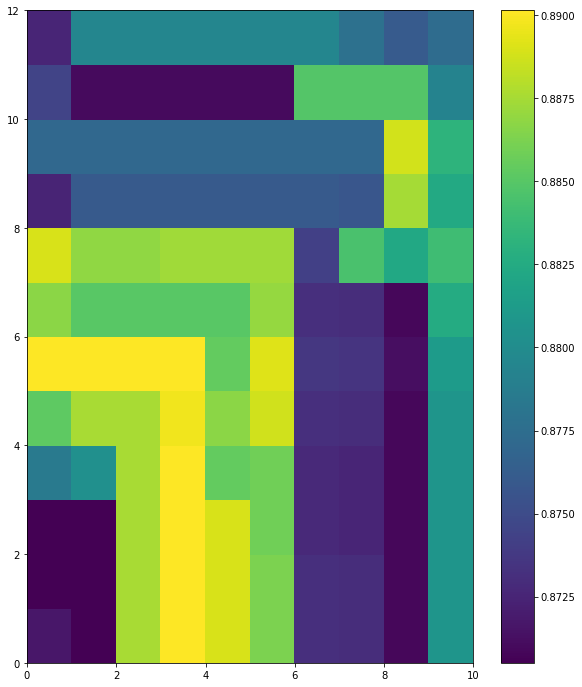

In [4]:
print('len radius:', len(ms_radius))
print('len btwdist:', len(ms_between_distances))

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)
#ax.matshow(IMG)

heatmap = ax.pcolor(IMG)
cbar = plt.colorbar(heatmap)

plt.show()